# Подготовка обучающего датасета для модели YOLO из видео
## Цель задания: 
**Получить практический опыт в создании базового датасета для детекции объектов в формате YOLO, используя видео продолжительностью 20 секунд и любой удобный инструмент разметки**

## 1.	Выбор видео:
* Выберите видео длительностью около 25 секунд. Видео должно содержать объекты, которые вы планируете детектировать (например, автомобили, люди, животные и т.д.).
*	Убедитесь, что качество видео достаточное для разметки (четкие изображения объектов).

При выборе видео необходимо учитывать наличие на нем четкого изображения объектов, котрые необходимо детектировать. При этом желательно наличие примерно одинакового количества кадров с детектирумыми объектами, а также их изображение с разных ракурсов.

В качестве такого видео используем файл "2.mp4", находящийся в директории "01_Задание_1" (см. структуру папок ниже):

## 2. Извлечение кадров:
* С помощью любого видеоредактора или скрипта извлеките кадры из видео.
* Рекомендуется извлекать кадры с интервалом, чтобы получить примерно 50 изображений.

### Импорт библиотек

In [1]:
import pandas as pd
import torch
import cv2
import os
import shutil
import natsort as ns
import json

### Для извлечения кадров используем скрипт ниже:

In [2]:
def video2frames(src, out, sample, xr, yr):
    
    if not os.path.exists(out):
        os.mkdir(out)
    
    cap = cv2.VideoCapture(src)
    
    if not cap.isOpened(): 
        print('Ошибка чтения видео-файла')
    
    i, s = 0, 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret == True:
            if i % sample == 0:
                frame = cv2.resize(frame, (xr, yr), cv2.INTER_NEAREST)
                cv2.imwrite(os.path.join(out, os.path.split(src)[-1].split('.')[0] + '_' + str(i) + '.jpg'), frame)
                s += 1
            i += 1
        else:
            break
    cap.release()
        
    return f'Задача завершена. Сохранено кадров: {s}.'

Функция читает видео по па адресу **src** по кадрам и сохраняет их как изображения в директорию **out**. Настраиваем выборку не всех, а каждого i-того кадра (параметр **sample** определяем ниже)

**Загрузка видео и определение директорий**

In [3]:
name_video = '2.mp4'
folder_video = '01_Задание_1'
src = os.path.join('..', folder_video, name_video)
out = os.path.join(os.curdir, 'frames')
cap = cv2.VideoCapture(src)

**Задаем размеры кадров для скрипта, выгрузив ширину и высоту видео**

In [4]:
new_x = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
new_y = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

**Определяем количество кадров видео. Затем, учитывая, что в соответствии с условиями задания, необходимое количество кадров для разметки равно примерно 50, определяем параметр sample**

In [5]:
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
sample = frame_count // 50

**Запускаем скрипт**

In [6]:
%%time

video2frames(src, out, sample, new_x, new_y)

CPU times: user 56 s, sys: 2.21 s, total: 58.2 s
Wall time: 38 s


'Задача завершена. Сохранено кадров: 56.'

### Создание вырезок 640х640

Далее из полученных кадров делаем вырезки 640х640 из собранных кадров, так как именно на 640х640 обучалась YOLO. 

640х640 - оптимальный размер изображений.

Для получения вырезок используем функцию **click_sampler**.
При запуске функции проиходит открытие стандратного окна OpenCV. Далее с помошью левой кнопки мыши отмечаем центр будущей вырезки на изображении: функция рисует границы вырезки и сохраняет данный фрагмент в указанную директорию (out).
В функции предусмотрен тот момент, что если указать центр вырезки близко к краю изображения, размер рамки остается 640х640 и смещается таким образом, что ее край свомещается с краем изображения.
- Любая кнопка на клавиатуре: вызывает следующее изображение.
- Скрипт завершится после обработки всех изображений!

Перед созданием функции **click_sampler** для исключения изображений неподходящего размера задаем функцию **set_coord_center**, которая будет смещать вырезку (точнее, указанный мышкой центр) в рамки фрейма, если границы вырезки выходят за границы фрейма.

In [7]:
def set_coord_center(xc, yc, size, img_x, img_y):
    limit_x = size[0] // 2
    limit_y = size[1] // 2
    if xc < limit_x:
        xc = limit_x
    if xc > img_x - limit_x:
        xc = img_x - limit_x
    if yc < limit_y:
        yc = limit_y
    if yc > img_y - limit_y:
        yc = img_y - limit_y
    return xc, yc

In [8]:
def click_sampler(name, size, out):
    
    if not os.path.exists(out):
        os.mkdir(out)
        
    if size[0] <= 0 or size[1] <= 0:
        raise ValueError ('Размер вырезки должен быть больше 0')
  
    img = cv2.imread(name)

    img_y, img_x = img.shape[0], img.shape[1]
    if size[0] > img_y or size[1] > img_x:
        print('Внимание: размер вырезки больше размера изображения')
        pass
    
    img_c = img.copy()

    cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    cv2.imshow(name, img)
    cv2.resizeWindow(name, img_y, img_x)

    coords = []
    
    def mouse_click(event, x, y, flags, param):
        
        if event == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(img, (x, y), 10, (0, 0, 255), -1)
            x, y = set_coord_center(x, y, size, img_x, img_y)
            x0, y0 = x - int(size[0]/2), y - int(size[1]/2)
            xw, yh = x + int(size[0]/2), y + int(size[1]/2)
                
            cv2.rectangle(img, (x0, y0), (xw, yh), (0, 0, 255), 3)
            cv2.imshow(name, img)
            coords.append((x, y))

        return coords

    cv2.setMouseCallback(name, mouse_click)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    t = 0
    nm, ext = os.path.basename(name.split('.')[0]), os.path.basename(name.split('.')[1])
    
    for coord in coords:
        x, y = coord[0], coord[1]
        
        x0, y0 = x - int(size[0]/2), y - int(size[1]/2)
        xw, yh = x + int(size[0]/2), y + int(size[1]/2)
        
        title = img_c[y0:yh, x0:xw]
        print(f"Создан фрейм {os.path.join(out, nm + '_' + str(x)+ 'x' + str(y) + '.' + ext)}")
        cv2.imwrite(os.path.join(out, nm + '_' + str(x) + 'x' + str(y) + '.' + ext), title)
                    
        t += 1
        
    return f'Создано вырезок: {t}'

**Применяем скрипт click_sampler итеративно для всех изображений в папке frame**

In [9]:
pth = 'frames'
out = '640x640'

out_pth = os.path.join(pth, out)

if not os.path.exists(out_pth):
    os.mkdir(out_pth)
for file in ns.natsorted(os.listdir(pth)):
    f = os.path.join(pth, file)
    if os.path.isfile(f): # для исключения ошибки при попытке обработать директорию
        print(os.path.join(out_pth, os.path.basename(file)))
        click_sampler(os.path.join(pth, os.path.basename(file)), (640,640), out_pth)

frames/640x640/2_0.jpg


Создан фрейм frames/640x640/2_0_1541x1840.jpg
Создан фрейм frames/640x640/2_0_2751x1148.jpg
Создан фрейм frames/640x640/2_0_1636x1142.jpg
Создан фрейм frames/640x640/2_0_1535x620.jpg
Создан фрейм frames/640x640/2_0_408x1420.jpg
Создан фрейм frames/640x640/2_0_3401x1840.jpg
Создан фрейм frames/640x640/2_0_2653x560.jpg
Создан фрейм frames/640x640/2_0_3204x754.jpg
Создан фрейм frames/640x640/2_0_2587x1840.jpg
Создан фрейм frames/640x640/2_0_3776x320.jpg
Создан фрейм frames/640x640/2_0_320x320.jpg
frames/640x640/2_7.jpg
frames/640x640/2_14.jpg
Создан фрейм frames/640x640/2_14_700x387.jpg
Создан фрейм frames/640x640/2_14_1553x369.jpg
Создан фрейм frames/640x640/2_14_3493x1634.jpg
Создан фрейм frames/640x640/2_14_2232x689.jpg
Создан фрейм frames/640x640/2_14_1511x1017.jpg
frames/640x640/2_21.jpg
frames/640x640/2_28.jpg
frames/640x640/2_35.jpg
frames/640x640/2_42.jpg
Создан фрейм frames/640x640/2_42_1627x352.jpg
Создан фрейм frames/640x640/2_42_1576x948.jpg
Создан фрейм frames/640x640/2_42_17

## 3. Разметка данных:
* Выберите любой инструмент для разметки данных (например, LabelImg, LabelMe, CVAT, VoTT и т.д.).
* Разметьте объекты на каждом кадре, используя bounding boxes, и присвойте им соответствующие классы.
* Убедитесь, что разметка сохранена в формате, совместимом с YOLO (текстовые файлы с координатами и метками классов).

Для разметки изображений будем использовать VGG Image Annotation (VIA) - браузерный инструмент разметки изображений для создания обучающих выборок.
Инструмент обладает рядом преимуществ, однако для возможности загрузки размеченных изображений в YOLO, будет необходим скрипт **VIA2YOLO_detect**, приведенный ниже.

В рамках задания будем размечать автомобили для решения задачи обнаружения (локализация объекта, определение его класса и примерных размеров на изображении). Используем разметку bounding boxes – ограничивающие прямоугольники.

### Порядок работы:
1. Открыв VIA в браузере, загружаем полученную выборку 640х640.
2. Выбираем тип разметки в меню Region Shape - для задачи детекции это Rectangle.
3. Настраиваем атрибуты файлов:
* заведомо пустые (не содержащие автомобили)
* один автомобиль
* два автомобиля
* много автомобилей
4. Также настраиваем атрибуты регионов разметки:
* Name - Object
* Type - Car (используем радио-кнопку; здесь не принципиально, т.к. класс один, но в случае нескольких классов объект обычно относится только к одному)
* Значение def зхдесь также не играет особой роли (значение класс по умолчанию)
5. Далее для каждого автомобиля создаем ограничивающие рамки, переходя к следующему изображению после заверешения обработки предыдущего.
6. При необходимости редактируем рамки или удаляем их.
7. После завершения разметки сохраняем результат в файл csv.

**Преобразуем полученные данные из файла csv в метку для каждого изображения**

In [12]:
def VIA2YOLO_detect(data, cls_codes, out_dir, imgsize):
    
    annot = pd.read_csv(data, index_col=0)
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    for label, row in annot.iterrows():
        name, r_count, coords, cls = label, int(row[2]), json.loads(row[4]), json.loads(row[5])
        cls = str(cls)
        
        # для изображений без объектов создаем пустые файлы разметки
        if r_count == 0:
            with open(os.path.join(out_dir, label.split('.')[0]) + '.txt', 'w') as f:
                f.write('')
        
        if r_count == 1:
            if coords['name'] == 'rect':
                xywh = []
                xywh.append(coords['x']/imgsize[0] + (coords['width']/imgsize[0])/2)
                xywh.append(coords['y']/imgsize[1] + (coords['height']/imgsize[1])/2)
                xywh.append(coords['width']/imgsize[0])
                xywh.append(coords['height']/imgsize[1])

                for key in cls_codes.keys():
                    if key in cls:
                        cls_id = cls_codes[key]

                fin_str = str(cls_id) + ' ' + str(xywh)[1:-1].replace(',','')

                with open(os.path.join(out_dir, label.split('.')[0]) + '.txt', 'w') as f:
                    f.write(fin_str + '\n')
            
        if r_count > 1:
            if coords['name'] == 'rect':
                xywh = []
                xywh.append(coords['x']/imgsize[0] + (coords['width']/imgsize[0])/2)
                xywh.append(coords['y']/imgsize[1] + (coords['height']/imgsize[1])/2)
                xywh.append(coords['width']/imgsize[0])
                xywh.append(coords['height']/imgsize[1])

                for key in cls_codes.keys():
                    if key in cls:
                        cls_id = cls_codes[key]

                fin_str = str(cls_id) + ' ' + str(xywh)[1:-1].replace(',','')

                with open(os.path.join(out_dir, label.split('.')[0]) + '.txt', 'a') as f:
                    f.write(fin_str + '\n')
    
    return annot['region_attributes'].value_counts()

In [13]:
data = 'via_project_14Nov2024_12h25m_csv.csv'
out_dir = 'labels' # директория с метками
# директория с изображениям "images/"

mcodes = {'car': 0} # единственный класс

VIA2YOLO_detect(data, mcodes, out_dir, (640, 640))

/tmp/ipykernel_11897/2728965611.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name, r_count, coords, cls = label, int(row[2]), json.loads(row[4]), json.loads(row[5])


region_attributes
{"Object":"car"}    298
{}                   22
Name: count, dtype: int64

**Открывая файлы, созданные по названиям изображений, видим для каждой созданной рамки строку следующего вида:**

0 0.865625 0.7140624999999999 0.075 0.040625

Здесь
* 0 - индекс класса (у нас один класс - car);
* 0.865625, 0.7140624999999999 - координаты центра в относительных величинах
* 0.075, 0.040625 - размеры прямоугольника в относительных величинах.

**Разметка соответствует формату YOLO**

## 4. Структура датасета:
* Создайте папки для изображений и аннотаций (например, images/ и labels/).
* Проверьте, что имена файлов изображений и соответствующих аннотаций совпадают (например, image1.jpg и image1.txt).

**Все полученные данные сохраняем в соответствующих директориях: для изображений "images/", для аннотаций "labels/".**

**Имена файлов изображений и соответствующих аннотаций совпадают. Количество файлов изображений равно количеству файлов аннотаций, т.к. для неразмеченных изображений автоматически создан пустой файл на этапе сохранения разметки в формат YOLO, что облегчает не обязательно, но значительно сократило время проверки**

## 5. Проверка данных:
* Выберите несколько изображений и убедитесь, что bounding boxes отображаются корректно.
* Проверьте формат аннотаций на соответствие требованиям YOLO.

**Для проверки корректности отображения bounding boxes, используем библиотеку OpenCV для 10% размеченных изображений**

In [27]:
def convert2cv(data, img_x, img_y):
    params = data.split()
    xc = int(float(params[1]) * img_x)
    yc = int(float(params[2]) * img_y)
    width = int(float(params[3]) * img_x)
    heigth = int(float(params[4]) * img_y)
    return xc, yc, width, heigth

In [28]:
def check_bb(images, labels, name):
    img = cv2.imread(os.path.join(images, name + '.jpg'))
    img_y, img_x = img.shape[0], img.shape[1]
    with open(os.path.join(labels, name + '.txt'), 'r') as l:
        bb = []
        for line in l:
            x, y, w, h = convert2cv(line, img_x, img_y)
            x0, y0 = x - w // 2, y + h // 2
            xw, yh = x + w // 2, y - h // 2
            bb.append(((x0, y0), (xw, yh)))
    for rect in bb:
        cv2.rectangle(img, rect[0], rect[1], (0,255,0), 3)
    cv2.imshow('Bounding boxes', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
pth = os.curdir
images = 'images'
labels = 'labels'
files = os.listdir(os.path.join(pth, images))
step = len(files) // 10 # 10% изображений
for i in range(0, len(files), step):
    check_bb(images, labels, files[i].split('.')[0])

**Как было отмечено в п.3, Разметка соответствует формату YOLO, в чем мы также убедились выше при посторении ограничивающих рамок.**

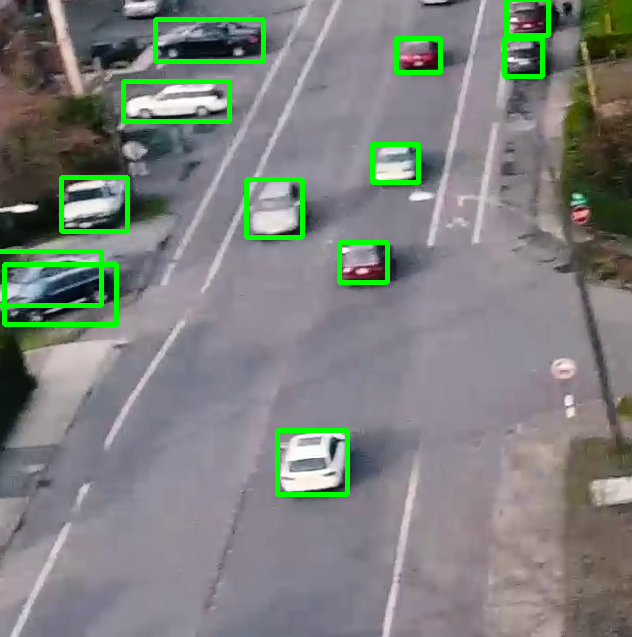

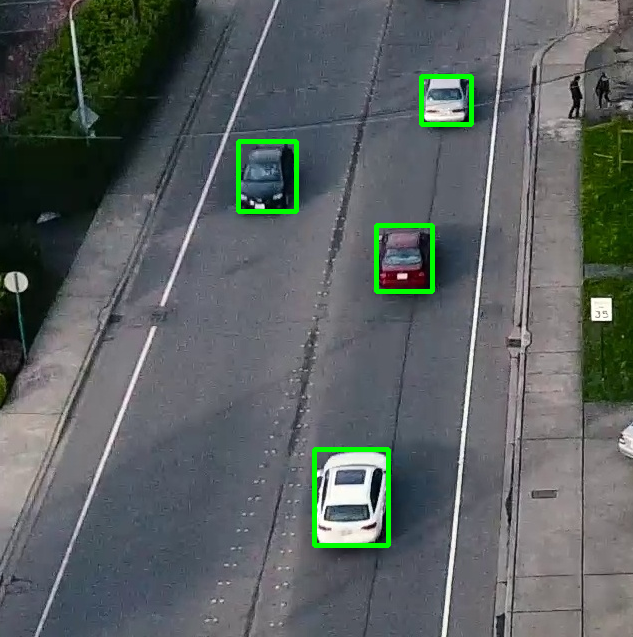

**В ходе выборки и разметки датасета могут возникнуть следующие трудности:**
* Низкая подвижность кадров и, как следствие, малый объем выборки
* Недостаточная четкость объектов
* Малое количество объектов

  _Данные факторы в дальнейшем могут повлиять на качество обучения модели_

**Также можно выделить субъективные факторы**
  
* Требует много времени
* При загрузке в существующую модель, может быть нарушена конфиденциальность персональных данных.
* Качество разметки может страдать из-за усталости разметчика, сложности или неоднозначности заданий.
